In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from tqdm import tqdm
import torchsummary

In [2]:
import tensorflow as tf
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True,
                                   )
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 2s 0us/step


In [3]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import transforms as T
t = T.Compose([T.Resize((224,224)),T.ToTensor(),T.Normalize((0.5,0.5,0.5), (0.25,0.25,0.25))])
dataset = ImageFolder(root = data_dir,transform = t)

In [43]:
train_size = int(dataset.__len__() * 0.8)
valid_size = dataset.__len__() - train_size

training_data, valid_data = random_split(dataset, [train_size, valid_size])

train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)

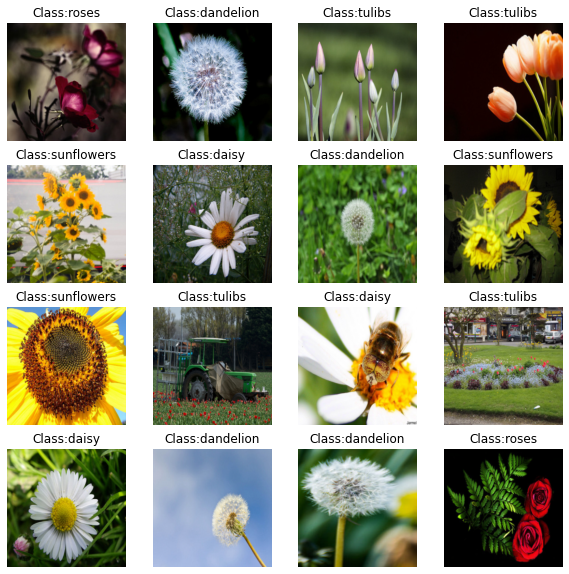

In [5]:
class_names = ['daisy','dandelion','roses','sunflowers','tulibs']
plt.figure(figsize=(10, 10))
images, labels = next(iter(train_loader))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  img = images[i]
  img = (img - img.min())/(img.max() - img.min())
  plt.imshow(img.permute(1, 2, 0).numpy())
  plt.title(f'Class:{class_names[labels[i]]}')
  plt.axis("off")

In [70]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), # batch_size[3, 244, 244] -> [64, 244, 244]
            nn.BatchNorm2d(64), # batch Normalization 추가
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) # [64, 244, 244] -> [64, 112, 112]
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # batch_size[64, 112, 112] -> [128, 112, 112]
            nn.BatchNorm2d(128), # batch Normalization 추가
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) #[128, 56, 56]
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=1), # batch_size[128, 56, 56] -> [256, 54, 54]
            nn.BatchNorm2d(256), # batch Normalization 추가
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) #[256, 27, 27]
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=5, stride=1, padding=1), # batch_size[256, 27, 27] -> [512, 25, 25]
            nn.BatchNorm2d(512), # batch Normalization 추가
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) #[512, 12, 12]
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=5, stride=1, padding=1), # batch_size[512, 12, 12] -> [1024, 10, 10]
            nn.BatchNorm2d(1024),# batch Normalization 추가
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))#[1024, 5, 5]
        
        self.fc1 = nn.Linear(25600, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 5)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = F.dropout(out, training=self.training)
        out = self.fc2(out)
        out = F.dropout(out, training=self.training)
        out = self.fc3(out)
        return F.log_softmax(out,dim=1)

In [71]:
model = CNN().to(gpu)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [72]:
torchsummary.summary(model,(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5        [-1, 128, 112, 112]          73,856
       BatchNorm2d-6        [-1, 128, 112, 112]             256
              ReLU-7        [-1, 128, 112, 112]               0
         MaxPool2d-8          [-1, 128, 56, 56]               0
            Conv2d-9          [-1, 256, 54, 54]         819,456
      BatchNorm2d-10          [-1, 256, 54, 54]             512
             ReLU-11          [-1, 256, 54, 54]               0
        MaxPool2d-12          [-1, 256, 27, 27]               0
           Conv2d-13          [-1, 512, 25, 25]       3,277,312
      BatchNorm2d-14          [-1, 512,

In [75]:
import torch, gc
gc.collect()
torch.cuda.empty_cache() # 캐시 초기화

In [80]:
epochs = 40
torch.cuda.empty_cache()    
train_losses = []
val_losses = []
train_acc = []
val_acc = []

for e in range(epochs):
    # training loop
    running_loss = 0       
    running_accuracy = 0 
    model.train()
    for _, data in enumerate(tqdm(train_loader)):
        # training phase            
        inputs, labels = data
        inputs = inputs.to(gpu).float()
        labels = labels.to(gpu).long()
        optimizer.zero_grad()  # reset gradient
        
        # forward        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)            

        # backward
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_accuracy += torch.sum(preds == labels.data).detach().cpu().numpy()/inputs.size(0)


    # validation loop
    model.eval()
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for _, data in enumerate(tqdm(valid_loader)):                
            inputs, labels = data
            inputs = inputs.to(gpu).float()
            labels = labels.to(gpu).long()

            # forward
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # evaluation metrics
            # loss
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_accuracy += torch.sum(preds == labels.data).detach().cpu().numpy()/inputs.size(0)

    # calculate mean for each batch
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss / len(valid_loader))
    train_acc.append(running_accuracy / len(train_loader))
    val_acc.append(val_accuracy / len(valid_loader))
    print("Epoch:{}/{}..".format(e + 1, epochs),
            "Train Loss: {:.3f}..".format(running_loss / len(train_loader)),
            "Val Loss: {:.3f}..".format(val_loss / len(valid_loader)),
            "Train Acc:{:.3f}..".format(running_accuracy / len(train_loader)),
            "Val Acc:{:.3f}..".format(val_accuracy / len(valid_loader)))

history = {'train_loss': train_losses, 'val_loss': val_losses,
            'train_acc': train_acc, 'val_acc': val_acc}

100%|██████████| 23/23 [00:04<00:00,  4.86it/s]


Epoch:1/40.. Train Loss: 0.618.. Val Loss: 0.681.. Train Acc:0.763.. Val Acc:0.767..


100%|██████████| 23/23 [00:04<00:00,  4.94it/s]


Epoch:2/40.. Train Loss: 0.610.. Val Loss: 0.807.. Train Acc:0.775.. Val Acc:0.754..


100%|██████████| 23/23 [00:04<00:00,  4.89it/s]


Epoch:3/40.. Train Loss: 0.585.. Val Loss: 0.857.. Train Acc:0.787.. Val Acc:0.728..


100%|██████████| 23/23 [00:04<00:00,  4.92it/s]


Epoch:4/40.. Train Loss: 0.573.. Val Loss: 0.749.. Train Acc:0.794.. Val Acc:0.751..


100%|██████████| 23/23 [00:04<00:00,  4.92it/s]


Epoch:5/40.. Train Loss: 0.520.. Val Loss: 0.710.. Train Acc:0.810.. Val Acc:0.756..


100%|██████████| 23/23 [00:04<00:00,  4.89it/s]


Epoch:6/40.. Train Loss: 0.506.. Val Loss: 0.752.. Train Acc:0.819.. Val Acc:0.771..


100%|██████████| 23/23 [00:05<00:00,  4.38it/s]


Epoch:7/40.. Train Loss: 0.475.. Val Loss: 0.701.. Train Acc:0.828.. Val Acc:0.771..


100%|██████████| 23/23 [00:04<00:00,  4.86it/s]


Epoch:8/40.. Train Loss: 0.484.. Val Loss: 0.798.. Train Acc:0.831.. Val Acc:0.739..


100%|██████████| 23/23 [00:04<00:00,  4.88it/s]


Epoch:9/40.. Train Loss: 0.414.. Val Loss: 0.862.. Train Acc:0.849.. Val Acc:0.733..


100%|██████████| 23/23 [00:04<00:00,  4.91it/s]


Epoch:10/40.. Train Loss: 0.498.. Val Loss: 0.724.. Train Acc:0.822.. Val Acc:0.778..


100%|██████████| 23/23 [00:04<00:00,  4.90it/s]


Epoch:11/40.. Train Loss: 0.425.. Val Loss: 0.733.. Train Acc:0.846.. Val Acc:0.784..


100%|██████████| 23/23 [00:04<00:00,  4.86it/s]


Epoch:12/40.. Train Loss: 0.333.. Val Loss: 0.845.. Train Acc:0.881.. Val Acc:0.770..


100%|██████████| 23/23 [00:04<00:00,  4.93it/s]


Epoch:13/40.. Train Loss: 0.374.. Val Loss: 0.649.. Train Acc:0.868.. Val Acc:0.790..


100%|██████████| 23/23 [00:04<00:00,  4.90it/s]


Epoch:14/40.. Train Loss: 0.321.. Val Loss: 0.915.. Train Acc:0.883.. Val Acc:0.754..


100%|██████████| 23/23 [00:04<00:00,  4.91it/s]


Epoch:15/40.. Train Loss: 0.313.. Val Loss: 0.825.. Train Acc:0.894.. Val Acc:0.766..


100%|██████████| 23/23 [00:04<00:00,  4.82it/s]


Epoch:16/40.. Train Loss: 0.284.. Val Loss: 0.824.. Train Acc:0.905.. Val Acc:0.771..


100%|██████████| 23/23 [00:04<00:00,  4.90it/s]


Epoch:17/40.. Train Loss: 0.243.. Val Loss: 0.840.. Train Acc:0.913.. Val Acc:0.788..


100%|██████████| 23/23 [00:04<00:00,  4.90it/s]


Epoch:18/40.. Train Loss: 0.228.. Val Loss: 1.026.. Train Acc:0.920.. Val Acc:0.760..


100%|██████████| 23/23 [00:04<00:00,  4.88it/s]


Epoch:19/40.. Train Loss: 0.216.. Val Loss: 1.053.. Train Acc:0.926.. Val Acc:0.775..


100%|██████████| 23/23 [00:04<00:00,  4.87it/s]


Epoch:20/40.. Train Loss: 0.226.. Val Loss: 0.984.. Train Acc:0.923.. Val Acc:0.770..


100%|██████████| 23/23 [00:05<00:00,  4.35it/s]


Epoch:21/40.. Train Loss: 0.196.. Val Loss: 0.866.. Train Acc:0.939.. Val Acc:0.816..


100%|██████████| 23/23 [00:04<00:00,  4.94it/s]


Epoch:22/40.. Train Loss: 0.197.. Val Loss: 0.832.. Train Acc:0.936.. Val Acc:0.793..


100%|██████████| 23/23 [00:04<00:00,  4.84it/s]


Epoch:23/40.. Train Loss: 0.146.. Val Loss: 0.950.. Train Acc:0.952.. Val Acc:0.782..


100%|██████████| 23/23 [00:04<00:00,  4.85it/s]


Epoch:24/40.. Train Loss: 0.143.. Val Loss: 1.297.. Train Acc:0.956.. Val Acc:0.764..


100%|██████████| 23/23 [00:04<00:00,  4.87it/s]


Epoch:25/40.. Train Loss: 0.224.. Val Loss: 0.933.. Train Acc:0.930.. Val Acc:0.755..


100%|██████████| 23/23 [00:04<00:00,  4.95it/s]


Epoch:26/40.. Train Loss: 0.184.. Val Loss: 0.994.. Train Acc:0.944.. Val Acc:0.774..


100%|██████████| 23/23 [00:04<00:00,  4.87it/s]


Epoch:27/40.. Train Loss: 0.106.. Val Loss: 1.240.. Train Acc:0.964.. Val Acc:0.772..


100%|██████████| 23/23 [00:04<00:00,  4.94it/s]


Epoch:28/40.. Train Loss: 0.148.. Val Loss: 1.164.. Train Acc:0.954.. Val Acc:0.748..


100%|██████████| 23/23 [00:04<00:00,  4.86it/s]


Epoch:29/40.. Train Loss: 0.146.. Val Loss: 1.166.. Train Acc:0.954.. Val Acc:0.763..


100%|██████████| 23/23 [00:04<00:00,  4.90it/s]


Epoch:30/40.. Train Loss: 0.154.. Val Loss: 1.142.. Train Acc:0.953.. Val Acc:0.759..


100%|██████████| 23/23 [00:04<00:00,  4.89it/s]


Epoch:31/40.. Train Loss: 0.101.. Val Loss: 1.074.. Train Acc:0.970.. Val Acc:0.780..


100%|██████████| 23/23 [00:04<00:00,  4.84it/s]


Epoch:32/40.. Train Loss: 0.113.. Val Loss: 1.204.. Train Acc:0.970.. Val Acc:0.756..


100%|██████████| 23/23 [00:04<00:00,  4.88it/s]


Epoch:33/40.. Train Loss: 0.117.. Val Loss: 1.420.. Train Acc:0.963.. Val Acc:0.731..


100%|██████████| 23/23 [00:04<00:00,  4.86it/s]


Epoch:34/40.. Train Loss: 0.126.. Val Loss: 1.299.. Train Acc:0.965.. Val Acc:0.771..


100%|██████████| 23/23 [00:04<00:00,  4.94it/s]


Epoch:35/40.. Train Loss: 0.063.. Val Loss: 1.465.. Train Acc:0.982.. Val Acc:0.773..


100%|██████████| 23/23 [00:04<00:00,  4.90it/s]


Epoch:36/40.. Train Loss: 0.089.. Val Loss: 1.378.. Train Acc:0.972.. Val Acc:0.743..


100%|██████████| 23/23 [00:04<00:00,  4.91it/s]


Epoch:37/40.. Train Loss: 0.108.. Val Loss: 1.572.. Train Acc:0.971.. Val Acc:0.744..


100%|██████████| 23/23 [00:05<00:00,  4.43it/s]


Epoch:38/40.. Train Loss: 0.118.. Val Loss: 1.419.. Train Acc:0.969.. Val Acc:0.767..


100%|██████████| 23/23 [00:04<00:00,  4.89it/s]


Epoch:39/40.. Train Loss: 0.072.. Val Loss: 1.859.. Train Acc:0.979.. Val Acc:0.751..


100%|██████████| 23/23 [00:04<00:00,  4.91it/s]

Epoch:40/40.. Train Loss: 0.118.. Val Loss: 1.174.. Train Acc:0.969.. Val Acc:0.762..


In [81]:
### Test
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for _, data in enumerate(tqdm(valid_loader)):
        inputs, labels = data                    
        inputs = inputs.to(gpu).float()            
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)                        
        y_pred += list(preds.detach().cpu().numpy())
        y_true += list(labels.detach().numpy())

100%|██████████| 23/23 [00:05<00:00,  4.55it/s]


In [82]:
### 예측 리포트
from sklearn.metrics import classification_report, confusion_matrix
print('\n Classification report \n\n',
  classification_report(
      y_true,
      y_pred,
       target_names=class_names
      )
  )


 Classification report 

               precision    recall  f1-score   support

       daisy       0.75      0.83      0.79       139
   dandelion       0.86      0.78      0.82       184
       roses       0.61      0.68      0.64       122
  sunflowers       0.79      0.84      0.82       138
      tulibs       0.78      0.66      0.71       151

    accuracy                           0.76       734
   macro avg       0.76      0.76      0.76       734
weighted avg       0.77      0.76      0.76       734



(<matplotlib.legend.Legend at 0x7f455ca7e610>, None)

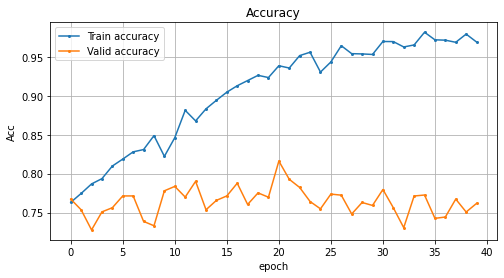

In [83]:
plt.figure(figsize = (8,4))
plt.plot(history['train_acc'],marker = 'o', ms = 2, label = "Train accuracy")
plt.plot(history['val_acc'],marker = 'o', ms = 2, label = "Valid accuracy")
plt.title(f'Accuracy');
plt.ylabel('Acc');
plt.xlabel('epoch')
plt.legend(), plt.grid()

(<matplotlib.legend.Legend at 0x7f455ca4da50>, None)

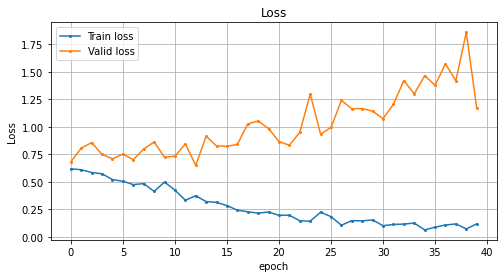

In [84]:
plt.figure(figsize = (8,4))
plt.plot(history['train_loss'],marker = 'o', ms = 2, label = "Train loss")
plt.plot(history['val_loss'],marker = 'o', ms = 2, label = "Valid loss")
plt.title(f'Loss');
plt.ylabel('Loss');
plt.xlabel('epoch')
plt.legend(), plt.grid()

- baseline 코드의 모델의 과대적합문제를 어느정도 해소 할 수 있었음
- 에포크 수를 늘리니 20회를 넘어가는 순간 loss가 증가함을 알 수 있었음